*La base des TDs pour le cours "Analyse de donn√©es massives 2" a √©t√© prise du cours en ligne "Open Machine Learning Course" (https://mlcourse.ai/, auteur Yury Kashnitsky)*

# <center> TD 4 : Apprentissage non supervis√©: PCA et clustering

Aujourd'hui, nous allons travailler avec des m√©thodes d'apprentissage non supervis√©es telles que l'analyse en composantes principales (ACP) et le clustering. Vous apprendrez pourquoi et comment nous pouvons r√©duire la dimensionnalit√© des donn√©es d'origine et quelles sont les principales approches pour regrouper des points de donn√©es similaires.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns 
sns.set()
# sns.set(style='white')

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Analyse en composantes principales (ACP)

L'analyse en composantes principales est l'une des m√©thodes les plus simples, les plus intuitives et les plus utilis√©es pour r√©duire la dimensionnalit√©, projetant des donn√©es sur son sous-espace d'entit√©s orthogonales.


<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">


Plus g√©n√©ralement, toutes les observations peuvent √™tre consid√©r√©es comme un ellipso√Øde dans un sous-espace d'un espace caract√©ristique initial, et la nouvelle base d√©finie dans ce sous-espace est align√©e avec les axes ellipso√Ødes. Cette hypoth√®se nous permet de supprimer les caract√©ristiques hautement corr√©l√©es puisque les vecteurs d'ensemble de base sont orthogonaux.
Dans le cas g√©n√©ral, la dimensionnalit√© ellipso√Øde r√©sultante correspond √† la dimensionnalit√© spatiale initiale, mais l'hypoth√®se que nos donn√©es se trouvent dans un sous-espace avec une dimension plus petite nous permet de couper l'espace "excessif" avec la nouvelle projection (sous-espace). 

### A. Exemple : Ensemble de donn√©es sur l'iris de Fisher

Commen√ßons par t√©l√©charger tous les modules essentiels et essayons l'exemple iris de la documentation `scikit-learn`.

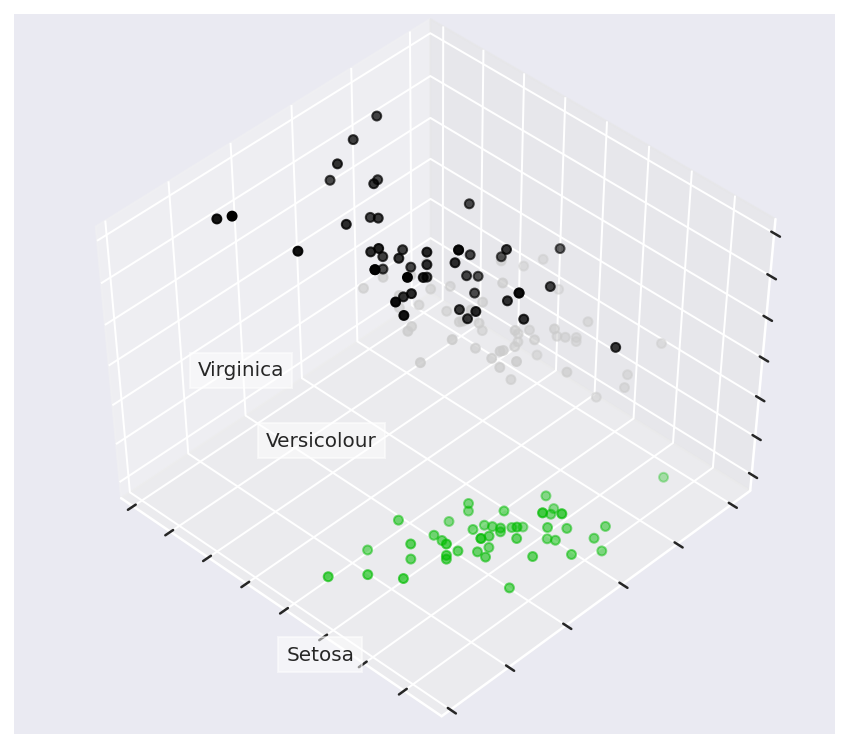

In [ ]:
from sklearn import decomposition
from sklearn import datasets

# Loading the dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Let's create a beautiful 3d-plot
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Change the order of labels, so that they match
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, 
           cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Voyons maintenant comment PCA am√©liorera les r√©sultats d'un mod√®le simple qui n'est pas capable d'ajuster correctement toutes les donn√©es d'entra√Ænement:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.88889


Essayons √† nouveau, mais, cette fois, r√©duisons la dimensionnalit√© √† 2 dimensions:

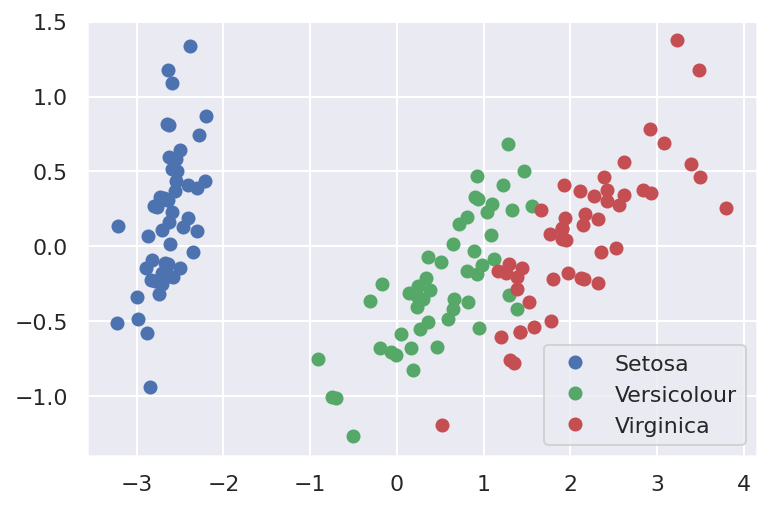

In [ ]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [ ]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


La pr√©cision n'a pas augment√© de mani√®re significative dans ce cas, mais, avec d'autres ensembles de donn√©es avec un nombre √©lev√© de dimensions, l'ACP peut consid√©rablement am√©liorer la pr√©cision des arbres de d√©cision et d'autres m√©thodes d'ensemble.

Voyons maintenant le pourcentage de variance qui peut √™tre expliqu√© par chacun des composants s√©lectionn√©s.

In [ ]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### B. Exemple : Ensemble de donn√©es de nombres manuscrits

Regardons l'ensemble de donn√©es de nombres manuscrits que nous avons utilis√© semaine derni√®re.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Commen√ßons par visualiser nos donn√©es. R√©cup√©rez les 10 premiers chiffres. Les nombres sont repr√©sent√©s par des matrices 8 x 8 avec l'intensit√© de couleur pour chaque pixel. Chaque matrice est aplatie en un vecteur de 64 nombres, nous obtenons donc la version caract√©ristique des donn√©es.

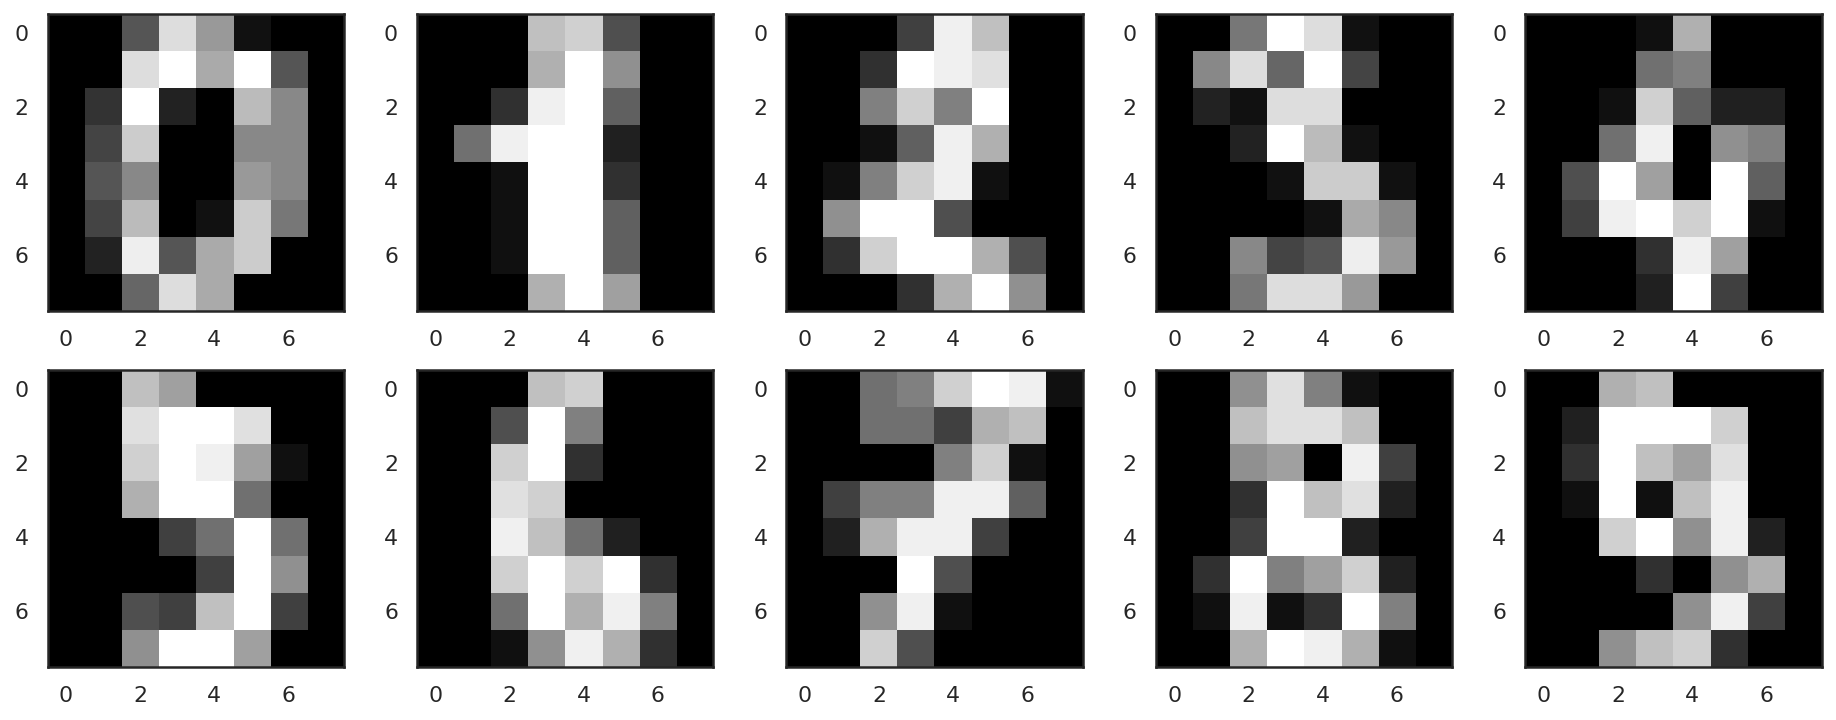

In [ ]:
with sns.axes_style("white"):
  plt.figure(figsize=(16, 6))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Nos donn√©es ont 64 dimensions, mais nous allons les r√©duire √† seulement 2 et voir que, m√™me avec seulement 2 dimensions, nous pouvons clairement voir que les chiffres se s√©parent en clusters.

Projecting 64-dimensional data to 2D


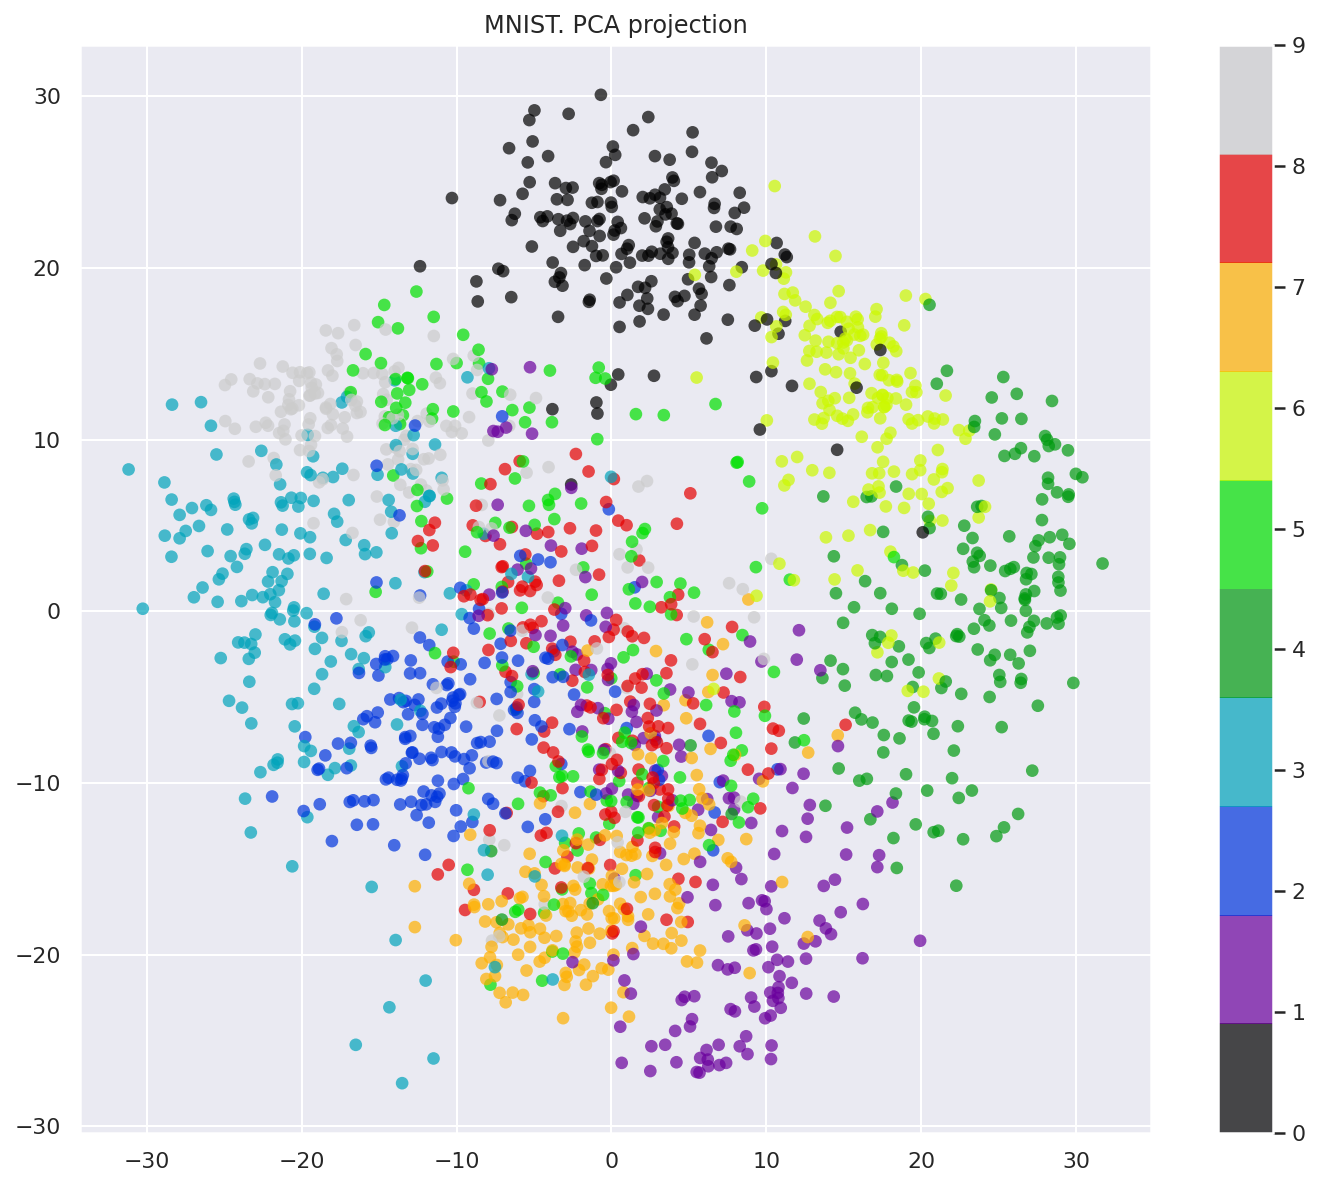

In [ ]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Dans la pratique, nous choisirions le nombre de composants principaux de fa√ßon √† pouvoir expliquer **90% de la dispersion initiale des donn√©es** (via le `explained_variance_ratio`). Ici, cela signifie conserver 20 composants principaux; par cons√©quent, nous r√©duisons la dimensionnalit√© de 64 entit√©s √† 20.

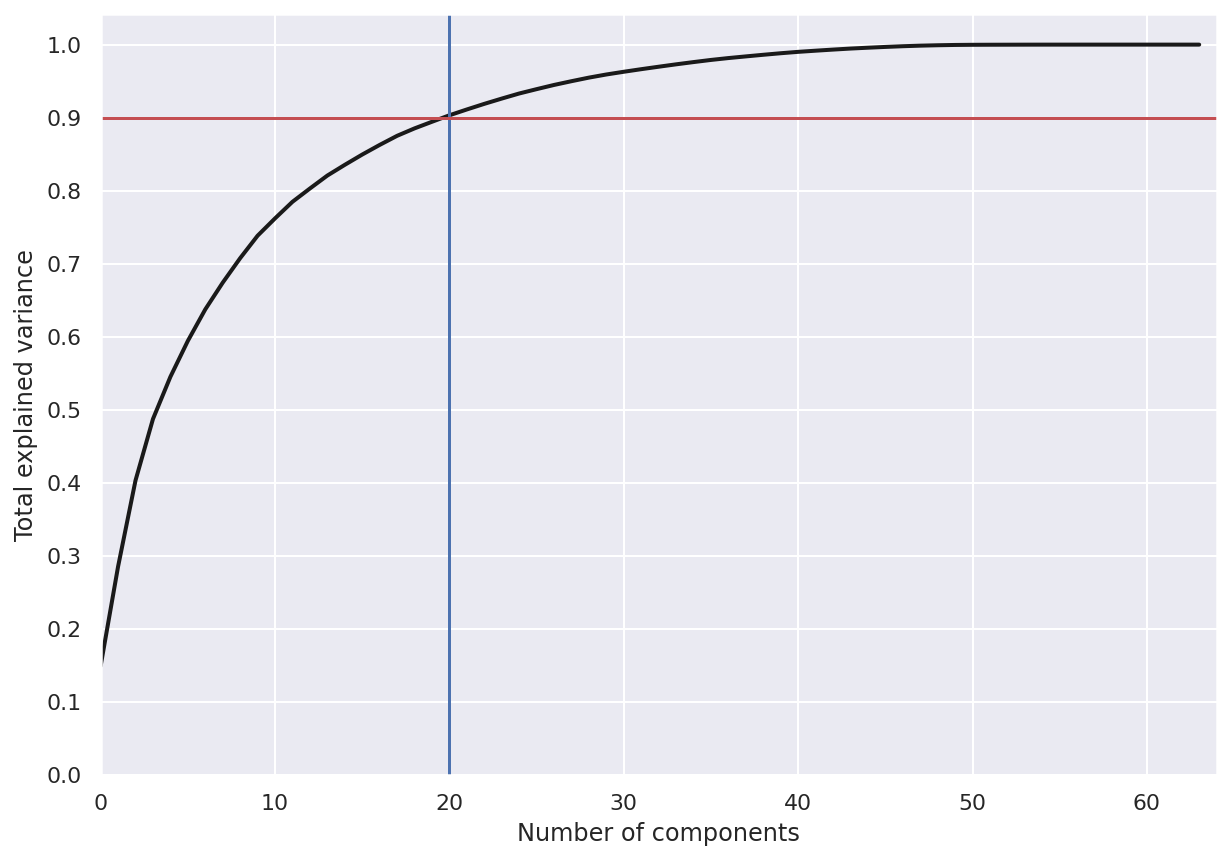

In [ ]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 64)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(20, c='b')
plt.axhline(0.9, c='r')
plt.show();

## 2. Clustering

L'id√©e principale derri√®re le clustering est assez simple. Fondamentalement, nous nous disons: ¬´J'ai ces points ici, et je peux voir qu'ils s'organisent en groupes. Ce serait bien de d√©crire ces choses plus concr√®tement et, quand un nouveau point arrive, de les affecter au bon groupe . " Cette id√©e g√©n√©rale encourage l'exploration et ouvre une vari√©t√© d'algorithmes pour le clustering.

<figure><img align="center" src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png"> 
<figcaption> Les exemples des r√©sultats de diff√©rents algorithmes de scikit-learn</figcaption>
</figure>

Les algorithmes r√©pertori√©s ci-dessous ne couvrent pas toutes les m√©thodes de clustering disponibles, mais ce sont les plus couramment utilis√©es.



### K-means

L'algorithme K-means est le plus populaire et le plus simple de tous les algorithmes de clustering. Voici comment cela fonctionne:
1. S√©lectionnez le nombre de clusters $k$ que vous pensez √™tre le nombre optimal.
2. Initialisez $k$ points comme des "centro√Ødes" au hasard dans l'espace de nos donn√©es.
3. Attribuez chaque observation √† son centro√Øde le plus proche.
4. Mettez √† jour les centro√Ødes au nouveau centre de l'ensemble des observations attribu√©es.
5. R√©p√©tez les √©tapes 3 et 4 un nombre fixe de fois ou jusqu'√† ce que tous les centro√Ødes soient stables (c'est-√†-dire qu'ils ne changent plus √† l'√©tape 4).

Cet algorithme est facile √† d√©crire et √† visualiser.

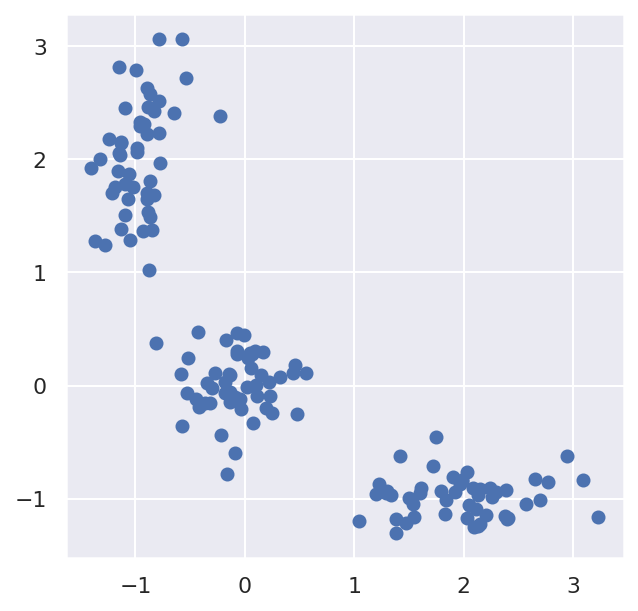

In [ ]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [ ]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

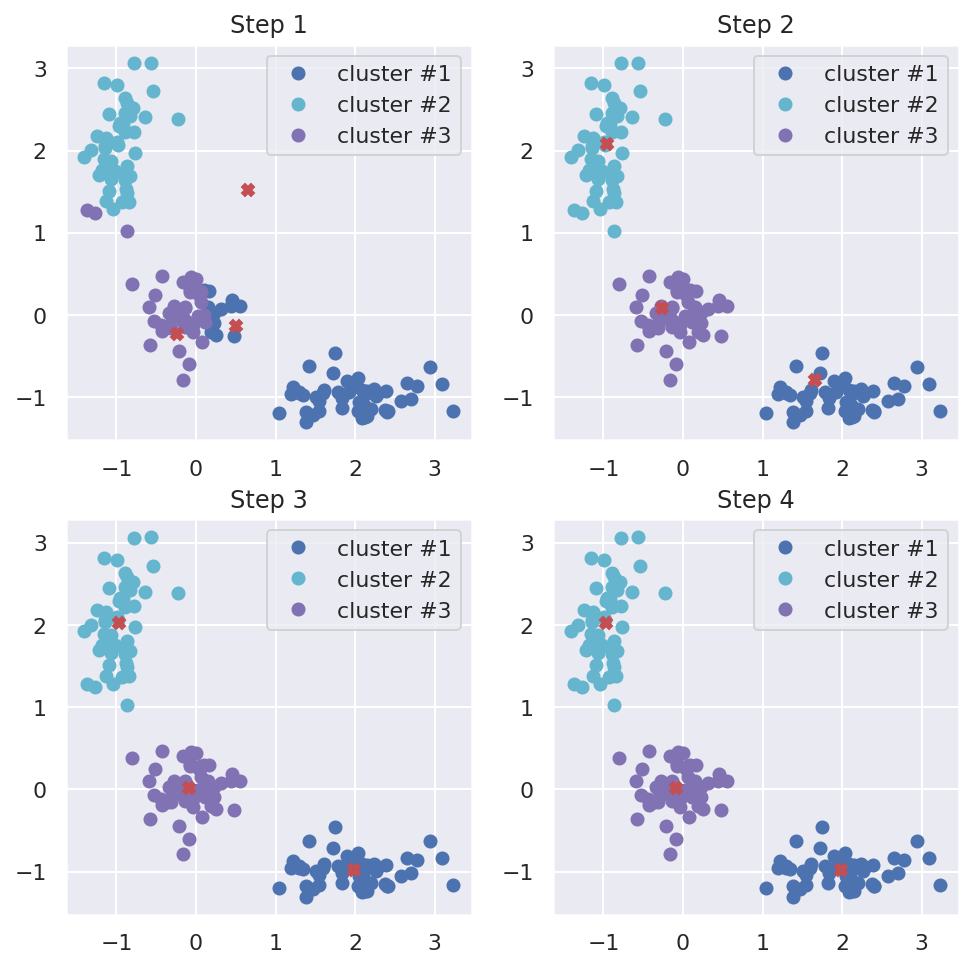

In [ ]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Nous avons utilis√© la distance euclidienne, mais l'algorithme convergera avec toute autre m√©trique. Vous pouvez non seulement faire varier le nombre d'√©tapes ou les crit√®res de convergence, mais √©galement la mesure de distance entre les points et les centro√Ødes de cluster.

Une autre "caract√©ristique" de cet algorithme est sa sensibilit√© aux positions initiales des centro√Ødes du cluster. Vous pouvez ex√©cuter l'algorithme plusieurs fois, puis faire la moyenne de tous les r√©sultats du centro√Øde.

#### Choix du nombre de clusters pour K-means

Contrairement aux t√¢ches d'apprentissage supervis√© telles que la classification et la r√©gression, le clustering n√©cessite plus d'efforts pour choisir le crit√®re d'optimisation. Habituellement, lorsque nous travaillons avec k-means, nous optimisons la somme des distances au carr√© entre les observations et leurs centro√Ødes.

$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

o√π $C$ - est un ensemble de clusters avec la puissance $K$, $\mu_k$ est un centre de gravit√© d'un cluster $C_k$.

Cette d√©finition semble raisonnable - nous voulons que nos observations soient aussi proches que possible de leurs centro√Ødes. Mais, il y a un probl√®me - l'optimum est atteint lorsque le nombre de centro√Ødes est √©gal au nombre d'observations, donc vous vous retrouveriez avec chaque observation comme son propre cluster s√©par√©.

Afin d'√©viter ce cas, nous devons choisir un certain nombre de clusters apr√®s quoi une fonction $J(C_k)$ diminue moins rapidement. Plus formellement,
$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Regardons un exemple.

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


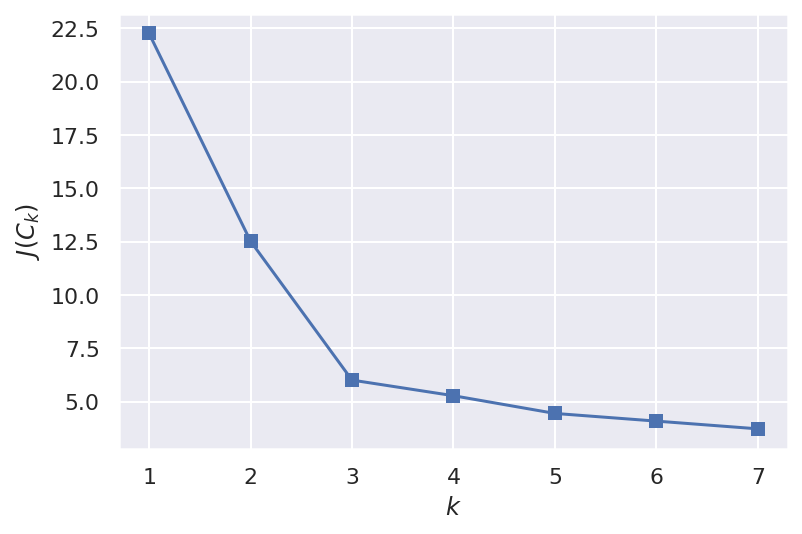

In [ ]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Nous voyons que $J(C_k)$ diminue de mani√®re significative jusqu'√† ce que le nombre de clusters soit de 3 puis ne change plus autant. Cela signifie que le nombre optimal de clusters est de 3.

### Mod√®le de m√©lange gaussien

Le mod√®le de m√©lange gaussien (GMM) tente de trouver un m√©lange de distributions de probabilit√© gaussiennes multidimensionnelles qui mod√©lisent le mieux n'importe quel ensemble de donn√©es d'entr√©e. 

Dans le cas le plus simple, GMMs peut √™tre utilis√© pour trouver des clusters de la m√™me mani√®re que k-means.



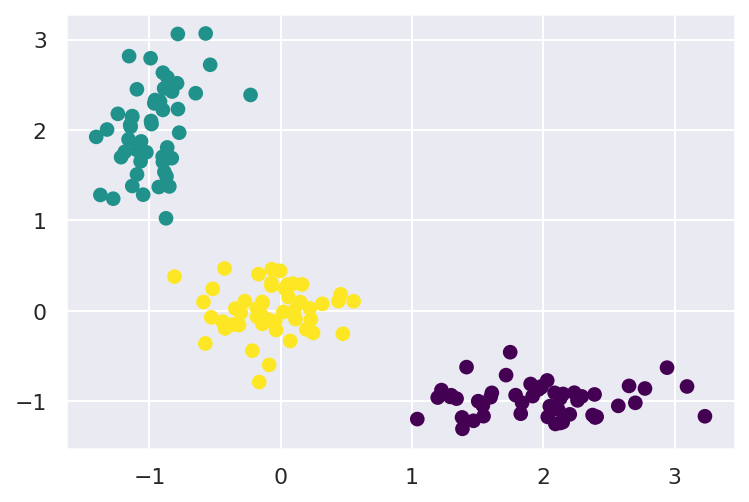

In [ ]:
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# plt.figure(figsize=(5, 5))
# plt.plot(X[:, 0], X[:, 1], 'bo');

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Le mod√®le de m√©lange gaussien est tr√®s similaire √† k-means. Il utilise une approche de maximisation des attentes qui fait qualitativement ce qui suit:

*   Choisissez des suppositions de d√©part pour les positions et formes;
*   R√©p√©ter jusqu'√† ce que cela converge :

> 1. *E-step*: pour chaque point, trouvez des poids codant la probabilit√© d'appartenance √† chaque cluster.
> 2. *M-step*: pour chaque cluster, mettez √† jour sa position, sa normalisation et sa forme en fonction de tous les points de donn√©es, en utilisant les poids.

En somme, chaque cluster est associ√© non pas √† une sph√®re √† bords durs, mais √† un mod√®le gaussien lisse. Tout comme dans l'approche k-means expectation‚Äìmaximization, cet algorithme peut parfois manquer la solution globalement optimale, et donc en pratique plusieurs initialisations al√©atoires sont utilis√©es.

Cr√©ons une fonction qui nous aidera √† visualiser les positions et les formes des clusters GMM en dessinant des ellipses bas√©es sur la sortie GMM:

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

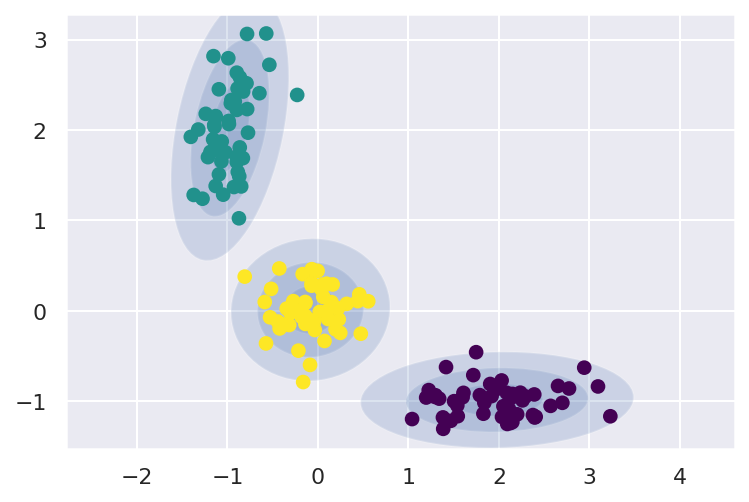

In [ ]:
gmm = GaussianMixture(n_components=3).fit(X)
plot_gmm(gmm, X)

Par contre, pour k-means les formes de clusters obtenus doivent √™tre circulaires, k-means n'a aucun moyen int√©gr√© de rendre compte des clusters oblongues ou elliptiques.

In [ ]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

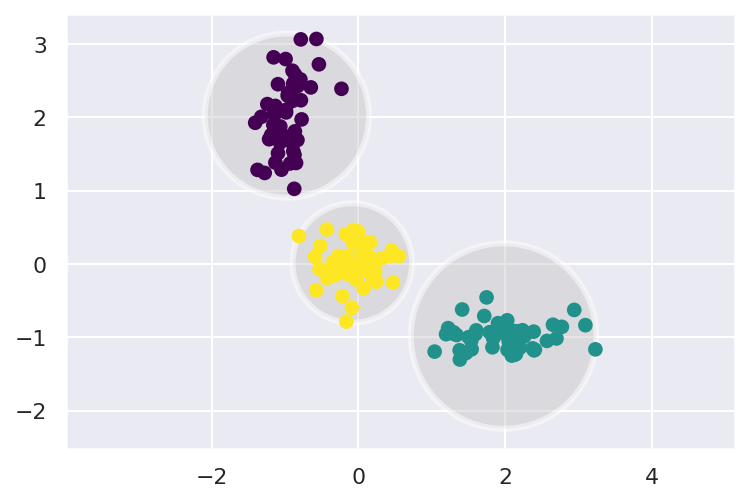

In [ ]:
kmeans = KMeans(n_clusters=3)
plot_kmeans(kmeans, X, n_clusters=3)

### Clustering agglom√©ratif (hi√©rarchique)

L'algorithme suivant est le plus simple et le plus facile √† comprendre parmi tous les algorithmes de clustering sans nombre fixe de clusters.


L'algorithme est assez simple:
1. Nous commen√ßons par assigner chaque observation √† son propre cluster
2. Ensuite, triez les distances par paires entre les centres des clusters dans l'ordre d√©croissant
3. Prenez les deux clusters voisins les plus proches et fusionnez-les, puis recalculez les centres
4. R√©p√©tez les √©tapes 2 et 3 jusqu'√† ce que toutes les donn√©es soient fusionn√©es en un seul cluster

Le processus de recherche du cluster le plus proche peut √™tre men√© avec diff√©rentes m√©thodes de d√©limitation des observations:
1. Liaison unique :
$$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$$
2. Lien complet :
$$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$$
3. Lien moyen :
$$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$$
4. Liaison centro√Øde :
$$d(C_i, C_j) = ||\mu_i - \mu_j||$$

Le 3√®me est le plus efficace en temps de calcul car il ne n√©cessite pas de recalculer les distances √† chaque fusion des clusters.

Les r√©sultats peuvent √™tre visualis√©s comme un bel arbre de cluster (dendogramme) pour aider √† reconna√Ætre le moment o√π l'algorithme doit √™tre arr√™t√© pour obtenir des r√©sultats optimaux. Il existe de nombreux outils Python pour construire ces dendogrammes pour le clustering agglom√©ratif.

Prenons un exemple avec les clusters que nous avons obtenus de K-means:

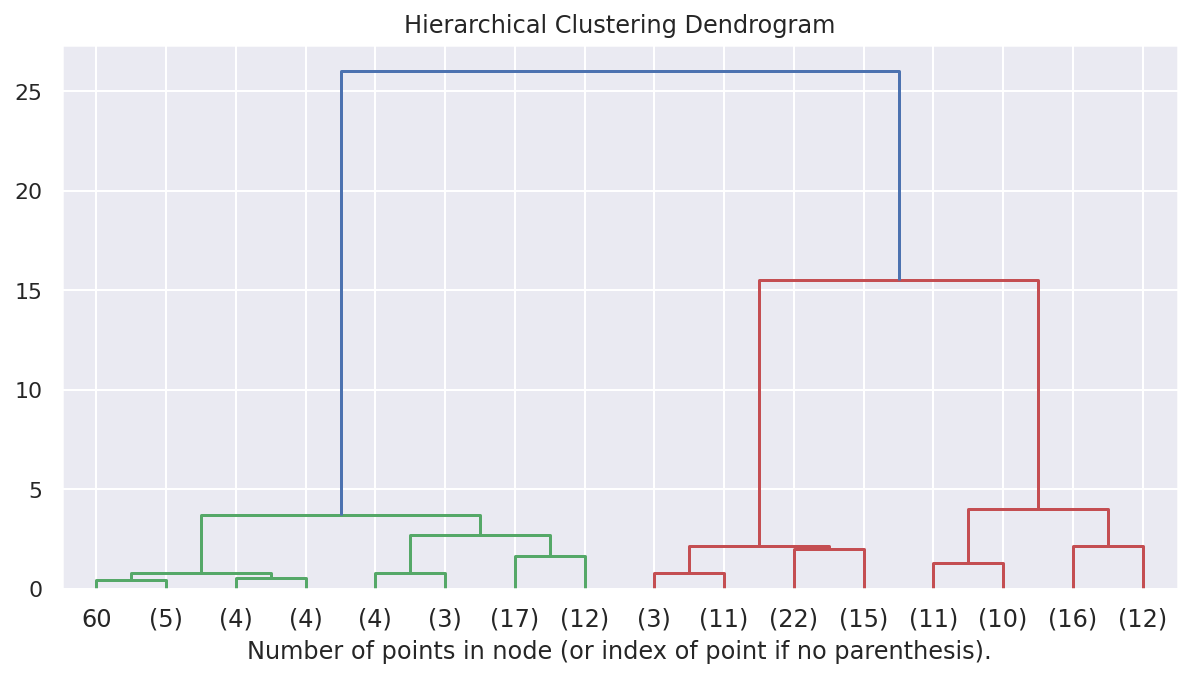

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg = agg.fit(X)

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

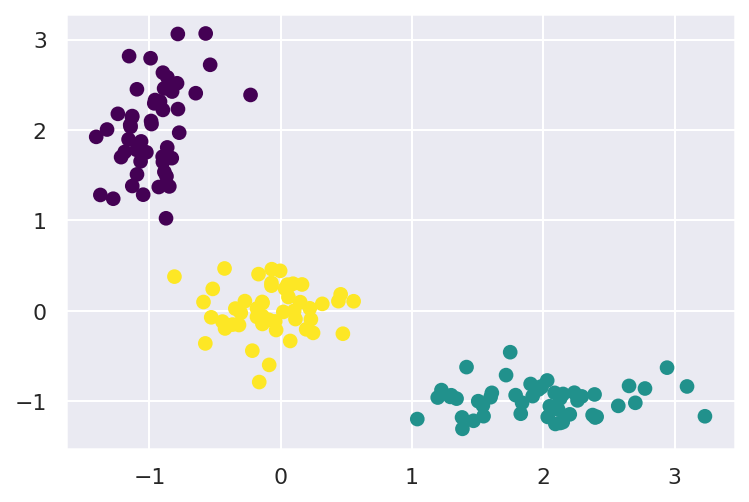

In [ ]:
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=agg_labels, s=40, cmap='viridis');

### Mesures de pr√©cision

Contrairement √† la classification, il est difficile d'√©valuer la qualit√© des r√©sultats du clustering. Ici, une m√©trique ne peut pas d√©pendre des √©tiquettes mais uniquement de la qualit√© de la division. Deuxi√®mement, nous n'avons g√©n√©ralement pas de v√©ritables √©tiquettes des observations lorsque nous utilisons le clustering.

Il existe des mesures de qualit√© *internes* et *externes*. Les m√©triques externes utilisent les informations sur la v√©ritable s√©paration connue tandis que les m√©triques internes n'utilisent aucune information externe et √©valuent la qualit√© des clusters en se basant uniquement sur les donn√©es initiales. Le nombre optimal de clusters est g√©n√©ralement d√©fini par rapport √† certaines m√©triques internes.

Toutes les m√©triques d√©crites ci-dessous sont impl√©ment√©es dans `sklearn.metrics`.

**Adjusted Rand Index (ARI)**

Ici, nous supposons que les v√©ritables √©tiquettes des objets sont connues. Cette m√©trique ne d√©pend pas des valeurs des √©tiquettes mais de la division du cluster de donn√©es. Soit $N$ le nombre d'observations dans un √©chantillon. Soit $a$ le nombre de paires d'observation avec les m√™mes √©tiquettes et situ√©es dans le m√™me cluster, et que $b$ soit le nombre de paires d'observation avec des √©tiquettes diff√©rentes et situ√©es dans diff√©rents clusters. L'indice Rand peut √™tre calcul√© √† l'aide de la formule suivante: $$\text{RI} = \frac{2(a + b)}{n(n-1)}.$$
En d'autres termes, il √©value une part de paires d'observation pour lesquelles ces divisions (r√©sultat initial et clustering) sont coh√©rentes. L'indice Rand (RI) √©value la similitude des deux divisions du m√™me √©chantillon. Pour que cet indice soit proche de z√©ro pour tout r√©sultat de clustering avec n'importe quel $n$ et nombre de clusters, il est essentiel de le mettre √† l'√©chelle, d'o√π l'indice Adjusted Rand Index: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Cette m√©trique est sym√©trique et ne d√©pend pas de la permutation d'√©tiquette. Par cons√©quent, cet indice est une mesure des distances entre diff√©rentes divisions d'√©chantillon. $\text{ARI}$ prend des valeurs dans la plage $[-1, 1]$. Les valeurs n√©gatives indiquent l'ind√©pendance des divisions et les valeurs positives indiquent que ces divisions sont coh√©rentes (elles correspondent √† $\text{ARI} = 1$).

**Adjusted Mutual Information (AMI)**

Cette m√©trique est similaire √† $\text{ARI}$. Elle est √©galement sym√©trique et ne d√©pend pas des valeurs et de la permutation des √©tiquettes. Il est d√©fini par la fonction [entropie](https://en.wikipedia.org/wiki/Entropy_(information_theory) et interpr√®te un √©chantillon divis√© comme une distribution discr√®te (la probabilit√© d'affecter √† un cluster est √©gal au pourcentage d'objets qu'il contient.) L'index $MI$ est d√©fini comme l'[information mutuelle](https://en.wikipedia.org/wiki/Mutual_information) pour deux distributions, correspondant √† l'√©chantillon divis√© en grappes. Intuitivement, les informations mutuelles mesurent la part des informations communes aux deux clusters, c'est-√†-dire comment les informations sur l'un d'entre eux diminuent l'incertitude de l'autre.

De la m√™me mani√®re que $\text{ARI}$, $\text{AMI}$ est d√©fini. Cela nous permet de nous d√©barrasser de l'augmentation de l'indice $MI$ avec le nombre de clusters. Le $\text{AMI}$ se situe dans la gamme $[0, 1]$. Des valeurs proches de z√©ro signifient que les divisions sont ind√©pendantes, et celles proches de 1 signifient qu'elles sont similaires (avec correspondance compl√®te √† $\text{AMI} = 1$).

**Homog√©n√©it√©, exhaustivit√©, V-mesure**

Formellement, ces m√©triques sont √©galement d√©finies en fonction de la fonction d'entropie et de la fonction d'entropie conditionnelle, interpr√©tant les r√©partitions d'√©chantillon comme des distributions discr√®tes: $$h = 1 - \frac{H(C\mid K)}{H(C)}, c = 1 - \frac{H(K\mid C)}{H(K)},$$
o√π $K$ est un r√©sultat de clustering et $C$ est la division initiale. Par cons√©quent, $h$ √©value si chaque cluster est compos√© des m√™mes objets de classe, et $c$ mesure dans quelle mesure les m√™mes objets de classe s'adaptent aux clusters. Ces m√©triques ne sont pas sym√©triques. Les deux se situent dans la plage $[0, 1]$, et des valeurs plus proches de 1 indiquent des r√©sultats de clustering plus pr√©cis. Les valeurs de ces m√©triques ne sont pas mises √† l'√©chelle comme le sont les m√©triques $\text{ARI}$ ou $\text{AMI}$ et d√©pendent donc du nombre de clusters. Un r√©sultat de clustering al√©atoire n'aura pas de valeurs de mesures plus proches de z√©ro lorsque le nombre de clusters est suffisamment grand et le nombre d'objets est petit. Dans un tel cas, il serait plus raisonnable d'utiliser $\text{ARI}$. Cependant, avec un grand nombre d'observations (plus de 100) et un nombre de grappes inf√©rieur √† 10, ce probl√®me est moins critique et peut √™tre ignor√©.

$V$-mesure (ùëâ-measure) est une combinaison de $h$ et $c$ et est leur moyenne harmonique:
$$v = 2\frac{hc}{h+c}.$$
Il est sym√©trique et mesure la coh√©rence de deux r√©sultats de regroupement.

**Silhouette**

Contrairement aux m√©triques d√©crites ci-dessus, ce coefficient n'implique pas la connaissance des v√©ritables √©tiquettes des objets. Il nous permet d'estimer la qualit√© du clustering en utilisant uniquement l'√©chantillon initial sans √©tiquette et le r√©sultat du clustering. Pour commencer, pour chaque observation, le coefficient de silhouette est calcul√©. Soit $a$ la moyenne de la distance entre un objet et d'autres objets au sein d'un cluster et $b$ la distance moyenne d'un objet aux objets du cluster le plus proche (diff√©rente de celle √† laquelle appartient l'objet). Ensuite, la mesure de silhouette pour cet objet est $$s = \frac{b - a}{\max(a, b)}.$$

La silhouette d'un √©chantillon est une valeur moyenne des valeurs de silhouette de cet √©chantillon. Par cons√©quent, la distance de la silhouette montre dans quelle mesure la distance entre les objets d'une m√™me classe diff√®re de la distance moyenne entre les objets de diff√©rents groupes. Ce coefficient prend des valeurs dans la plage $[-1, 1]$. Des valeurs proches de -1 correspondent √† de mauvais r√©sultats de clustering tandis que des valeurs plus proches de 1 correspondent √† des clusters denses et bien d√©finis. Par cons√©quent, plus la valeur de silhouette est √©lev√©e, meilleurs sont les r√©sultats du clustering.

√Ä l'aide de silhouette, nous pouvons identifier le nombre optimal de grappes $k$ (si nous ne le savons pas d√©j√† √† partir des donn√©es) en prenant le nombre de grappes qui maximise le coefficient de silhouette.

Pour conclure, examinons comment ces mesures fonctionnent avec le m√™me jeu de donn√©es :

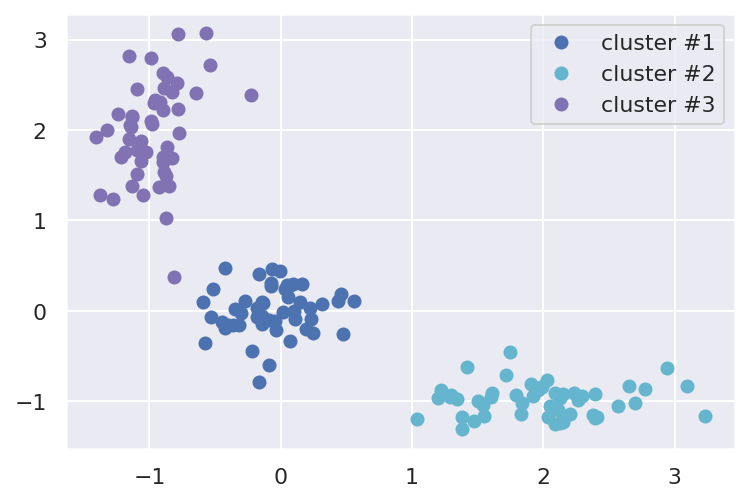

In [ ]:
X = np.zeros((150, 2))
y = np.zeros(150)

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)
y[:50] = 0

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)
y[50:100] = 1

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)
y[100:150] = 2

# data = datasets.load_digits()
# X, y = data.data, data.target


plt.plot(X[:50, 0], X[:50, 1], 'bo', label='cluster #1')
plt.plot(X[50:100, 0], X[50:100, 1], 'co', label='cluster #2')
plt.plot(X[100:150, 0], X[100:150, 1], 'mo', label='cluster #3')
plt.legend(loc=0)
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

algorithms = []
algorithms.append(KMeans(n_clusters=3, random_state=1))
algorithms.append(AgglomerativeClustering(n_clusters=3))
algorithms.append(GaussianMixture(n_components=3))

data = []
for algo in algorithms:
    algo.fit(X)
    labels = algo.fit_predict(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, labels),
        'AMI': metrics.adjusted_mutual_info_score(y, labels),
        'Homogenity': metrics.homogeneity_score(y, labels),
        'Completeness': metrics.completeness_score(y, labels),
        'V-measure': metrics.v_measure_score(y, labels),
        'Silhouette': metrics.silhouette_score(X, labels)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means','Agglomerative', 'GaussianMixture'])

results

ARI       AMI  ...  V-measure  Silhouette
K-means          0.979932  0.969818  ...   0.970191    0.721038
Agglomerative    0.979932  0.969818  ...   0.970191    0.721038
GaussianMixture  0.979932  0.969818  ...   0.970191    0.721038

[3 rows x 6 columns]

## 3. Liens utiles
- Overview of clustering methods in the [scikit-learn doc](https://scikit-learn.org/stable/modules/clustering.html).
- [Q&A](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) for PCA with examples